<a href="https://colab.research.google.com/github/meedastitou/computer-vision/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from ultralytics import YOLO
import yaml
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Literal
from PIL import Image
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
class CFG:
  DEBUG = False
  SEED = 42
  DATASET_PATH = '/content/drive/MyDrive/dataset'
  NAME = 'detection-PPE'

  CLASSES = ['Gloves', 'Glasses', 'Shoes', 'Helmet', 'Vest', 'Person']
  NUM_CLASSES_TO_TRAIN = len(CLASSES)
  NUM_CORES = os.cpu_count()
  # training
  EPOCHS = 3 if DEBUG else 50
  BATCH_SIZE = 16
  OPTIMIZER = 'AdamW' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
  LR = 1e-3
  LR_FACTOR = 0.01
  WEIGHT_DECAY = 5e-4
  DROPOUT = 0.0
  PATIENCE = 20
  PROFILE = False
  LABEL_SMOOTHING = 0.0


  # model
  YOLO_MODEL = "yolov8n.pt"

  # output

  OUTPUT_DIR = "/content/drive/MyDrive/PPE-detection/runs"
  ARTIFACTS = '/content/drive/MyDrive/PPE-detection/artifacts'

In [5]:
os.makedirs(CFG.ARTIFACTS, exist_ok=True)
os.makedirs(CFG.OUTPUT_DIR, exist_ok=True)

In [6]:
dict_yaml_file = {
    'train': os.path.join(CFG.DATASET_PATH, 'train'),
    'test' : os.path.join(CFG.DATASET_PATH, 'test'),
    'val'  : os.path.join(CFG.DATASET_PATH, 'valid'),
    'nc'   : CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
}

In [7]:
def create_yaml_file(file_path = CFG.DATASET_PATH, data = dict_yaml_file):

    with open(os.path.join(file_path, 'data.yaml'), 'w+') as file:
        yaml.dump(data, file)

In [8]:
def read_yaml_file(file_path = CFG.DATASET_PATH):
    with open(os.path.join(file_path, 'data.yaml'), 'r') as file:
        try :
            return yaml.safe_load(file)
        except yaml.YAMLError as e:
            print(e)
        except Exception as e:
            print(e)

In [9]:
### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

In [10]:
create_yaml_file()

In [11]:
yaml_data = read_yaml_file()

In [12]:
print_yaml_data(yaml_data)

names:
- Gloves
- Glasses
- Shoes
- Helmet
- Vest
- Person
nc: 6
test: /content/drive/MyDrive/dataset/test
train: /content/drive/MyDrive/dataset/train
val: /content/drive/MyDrive/dataset/valid



In [13]:
def display_one_image(image, print_info = True, axis : Literal['off', 'on'] = 'off'):

    if isinstance(image, str):
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print(f"type : {type(img)}\n")
        print(f"shape : {np.array(img).shape}\n")
    plt.axis(axis)
    plt.show()

In [14]:
# Load fresh model
model = YOLO(CFG.YOLO_MODEL)

100%|██████████| 6.25M/6.25M [00:00<00:00, 364MB/s]


In [15]:
# Full training
print("Starting training ...............")
model.train(
    data=os.path.join(CFG.DATASET_PATH, 'data.yaml'),
    epochs=CFG.EPOCHS,
    imgsz=640,
    batch=CFG.BATCH_SIZE,
    device=0,
    workers=CFG.NUM_CORES,
    project= CFG.OUTPUT_DIR,
    name=CFG.NAME,
    seed=CFG.SEED,
    optimizer=CFG.OPTIMIZER,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    verbose = False,

)
print("Training complete!")
print(f"Training complete! Results saved in {CFG.OUTPUT_DIR}/{CFG.NAME}")

Starting training ...............
Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=2, project=/content/drive/MyDrive/PPE-detection/runs, name=detection-PPE, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

100%|██████████| 755k/755k [00:00<00:00, 101MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    752482  ultralytics.nn.modules.head.Detect           [6, [64, 128, 256]]           
Model summary: 129 layers, 3,012,018 parameters, 3,012,002 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 238MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.2 ms, read: 0.1±0.0 MB/s, size: 80.0 KB)


train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 4783 images, 580 backgrounds, 5 corrupt: 100%|██████████| 4913/4913 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.8±0.2 ms, read: 0.1±0.0 MB/s, size: 74.2 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 313 images, 66 backgrounds, 0 corrupt: 100%|██████████| 313/313 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPE/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPE
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.56G      1.652      2.168      1.544         53        640: 100%|██████████| 307/307 [59:14<00:00, 11.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

                   all        313       1059      0.553      0.379      0.471      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.74G      1.639      1.908      1.542         79        640: 100%|██████████| 307/307 [01:54<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]

                   all        313       1059      0.559      0.544      0.534      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.76G       1.57        1.8      1.496        119        640: 100%|██████████| 307/307 [01:52<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

                   all        313       1059      0.579      0.469       0.56      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.94G      1.495      1.699      1.446        117        640: 100%|██████████| 307/307 [01:51<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]

                   all        313       1059      0.727      0.515      0.643      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.15G      1.433       1.57       1.41         79        640: 100%|██████████| 307/307 [01:51<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

                   all        313       1059      0.715      0.645      0.695      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.15G        1.4      1.505      1.388         86        640: 100%|██████████| 307/307 [01:51<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

                   all        313       1059       0.77      0.684      0.733      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.15G      1.363      1.452      1.369        119        640: 100%|██████████| 307/307 [01:53<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]

                   all        313       1059      0.826      0.669      0.739      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.15G      1.329      1.381      1.336         48        640: 100%|██████████| 307/307 [01:51<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

                   all        313       1059      0.837      0.689      0.759      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.15G      1.316      1.369      1.333         70        640: 100%|██████████| 307/307 [01:51<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

                   all        313       1059      0.804      0.666      0.736      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.15G      1.301       1.32      1.319         99        640: 100%|██████████| 307/307 [01:51<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

                   all        313       1059      0.846      0.715      0.771      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.15G      1.285      1.297       1.31         97        640: 100%|██████████| 307/307 [01:49<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

                   all        313       1059      0.803       0.72      0.774      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.15G      1.261      1.255      1.293         89        640: 100%|██████████| 307/307 [01:51<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]

                   all        313       1059      0.826      0.745      0.795      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.17G      1.254      1.261      1.291         78        640: 100%|██████████| 307/307 [01:51<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        313       1059      0.883       0.73        0.8      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.19G      1.248      1.221      1.284         72        640: 100%|██████████| 307/307 [01:51<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]

                   all        313       1059      0.822      0.764       0.81       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       3.2G      1.228      1.203      1.276        140        640: 100%|██████████| 307/307 [01:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]

                   all        313       1059      0.902      0.733      0.813      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       3.2G      1.213      1.162      1.263         67        640: 100%|██████████| 307/307 [01:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]

                   all        313       1059       0.86      0.771      0.824      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       3.2G      1.208      1.139      1.256        144        640: 100%|██████████| 307/307 [01:52<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

                   all        313       1059      0.846      0.755       0.81      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       3.2G      1.197      1.145      1.254         94        640: 100%|██████████| 307/307 [01:51<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        313       1059      0.876      0.773      0.822      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       3.2G      1.188      1.127      1.251         94        640: 100%|██████████| 307/307 [01:52<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        313       1059      0.878      0.785      0.834      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.2G      1.188      1.111      1.251         54        640: 100%|██████████| 307/307 [01:49<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

                   all        313       1059      0.893       0.78      0.839      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.21G      1.169      1.092      1.236         95        640: 100%|██████████| 307/307 [01:50<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]

                   all        313       1059      0.831      0.792      0.836      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.21G      1.153      1.058      1.221         55        640: 100%|██████████| 307/307 [01:50<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]

                   all        313       1059      0.883      0.773       0.83      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.21G      1.161      1.072       1.23        130        640: 100%|██████████| 307/307 [01:50<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

                   all        313       1059      0.907      0.763      0.829      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.21G      1.144      1.053      1.223         75        640: 100%|██████████| 307/307 [01:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

                   all        313       1059      0.856      0.781      0.832      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.22G      1.135      1.035      1.212        106        640: 100%|██████████| 307/307 [01:51<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]

                   all        313       1059      0.904      0.785      0.841      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.22G       1.13      1.034      1.211         56        640: 100%|██████████| 307/307 [01:50<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

                   all        313       1059      0.896      0.804       0.86      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.22G      1.127      1.009      1.206         66        640: 100%|██████████| 307/307 [01:49<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

                   all        313       1059      0.905      0.781      0.859      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.22G      1.107     0.9997      1.198        152        640: 100%|██████████| 307/307 [01:52<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]

                   all        313       1059       0.89      0.801      0.853      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.22G      1.109     0.9886      1.192         91        640: 100%|██████████| 307/307 [01:53<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]

                   all        313       1059      0.882      0.804      0.847      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.22G       1.09      0.966      1.187        112        640: 100%|██████████| 307/307 [01:52<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        313       1059      0.898      0.818      0.861       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.22G      1.087     0.9528      1.178         85        640: 100%|██████████| 307/307 [01:55<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

                   all        313       1059      0.925      0.808      0.865      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.22G      1.081     0.9538      1.179        110        640: 100%|██████████| 307/307 [01:54<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]

                   all        313       1059      0.901      0.811      0.866      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.22G      1.068     0.9292      1.173         56        640: 100%|██████████| 307/307 [01:52<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]

                   all        313       1059      0.917      0.815      0.865       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.22G       1.08     0.9186      1.176         98        640: 100%|██████████| 307/307 [01:52<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

                   all        313       1059      0.906      0.822      0.871      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.22G      1.061     0.9208      1.173         81        640: 100%|██████████| 307/307 [01:53<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

                   all        313       1059      0.897      0.824       0.87      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.22G      1.054     0.8962       1.16         97        640: 100%|██████████| 307/307 [01:53<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

                   all        313       1059      0.921      0.824      0.884      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.22G      1.053     0.9015      1.159         54        640: 100%|██████████| 307/307 [01:54<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]

                   all        313       1059      0.901      0.823      0.869      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.22G      1.046     0.8926       1.16        102        640: 100%|██████████| 307/307 [01:52<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

                   all        313       1059      0.929      0.825      0.875      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.22G      1.028       0.87       1.15        109        640: 100%|██████████| 307/307 [01:54<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]

                   all        313       1059       0.89       0.84      0.876      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.22G      1.015     0.8539      1.137        109        640: 100%|██████████| 307/307 [01:53<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]

                   all        313       1059       0.95      0.819      0.891      0.604


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.22G      1.035     0.8029      1.172         51        640: 100%|██████████| 307/307 [01:50<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]

                   all        313       1059      0.917      0.836      0.884      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.22G      1.024     0.7783      1.164         62        640: 100%|██████████| 307/307 [01:48<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]

                   all        313       1059      0.921       0.84      0.895      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.22G      1.002     0.7549      1.152         56        640: 100%|██████████| 307/307 [01:48<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]

                   all        313       1059      0.933      0.847      0.898      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.22G     0.9993     0.7531       1.15         44        640: 100%|██████████| 307/307 [01:49<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]

                   all        313       1059       0.93      0.839      0.894      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.22G     0.9862     0.7362      1.144         50        640: 100%|██████████| 307/307 [01:50<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

                   all        313       1059      0.932      0.849        0.9      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.22G     0.9771     0.7212      1.134         57        640: 100%|██████████| 307/307 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

                   all        313       1059      0.945       0.85      0.901      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.22G     0.9729     0.7205      1.138         39        640: 100%|██████████| 307/307 [01:45<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

                   all        313       1059      0.939      0.848      0.896      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.22G     0.9632     0.7016       1.13         37        640: 100%|██████████| 307/307 [01:45<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]

                   all        313       1059      0.926      0.863      0.903      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.22G     0.9486     0.7006      1.124         51        640: 100%|██████████| 307/307 [01:45<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

                   all        313       1059      0.947      0.843      0.898      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.22G      0.946     0.6911       1.12         44        640: 100%|██████████| 307/307 [01:44<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

                   all        313       1059      0.938      0.852        0.9      0.619



50 epochs completed in 2.561 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPE/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPE/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPE/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


                   all        313       1059      0.938      0.852        0.9      0.618
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPE
Training complete!
Training complete! Results saved in /content/drive/MyDrive/PPE-detection/runs/detection-PPE


In [16]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (640, 640),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics 8.3.121 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/PPE-detection/runs/detection-PPE/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (6.0 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 183.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.1s, installed 1 package: ['onnx>=1.12.0']
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 6.0s, saved as '/content/drive/MyDrive/PPE-detection/runs/detection-PPE/weights/best.onnx' (11.7 MB)

Export complete (7.8s)
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPE/weights
Predict:         yolo predict task=detect 

'/content/drive/MyDrive/PPE-detection/runs/detection-PPE/weights/best.onnx'

In [23]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}/{CFG.NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}/{CFG.NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/content/drive/MyDrive/PPE-detection/runs/detection-PPE/PR_curve.png',
 '/content/drive/MyDrive/PPE-detection/runs/detection-PPE/F1_curve.png',
 '/content/drive/MyDrive/PPE-detection/runs/detection-PPE/P_curve.png',
 '/content/drive/MyDrive/PPE-detection/runs/detection-PPE/R_curve.png',
 '/content/drive/MyDrive/PPE-detection/runs/detection-PPE/confusion_matrix_normalized.png',
 '/content/drive/MyDrive/PPE-detection/runs/detection-PPE/confusion_matrix.png',
 '/content/drive/MyDrive/PPE-detection/runs/detection-PPE/results.png',
 '/content/drive/MyDrive/PPE-detection/runs/detection-PPE/labels_correlogram.jpg',
 '/content/drive/MyDrive/PPE-detection/runs/detection-PPE/labels.jpg']

/content/drive/MyDrive/PPE-detection/runs/detection-PPE/F1_curve.png


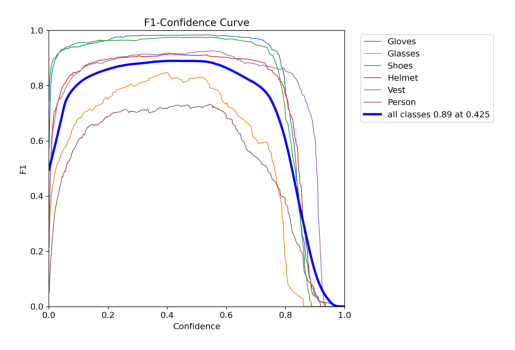



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/PR_curve.png


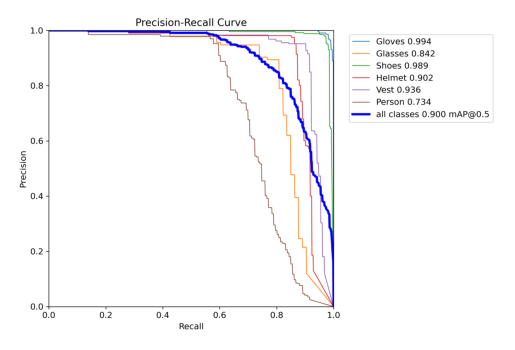



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/P_curve.png


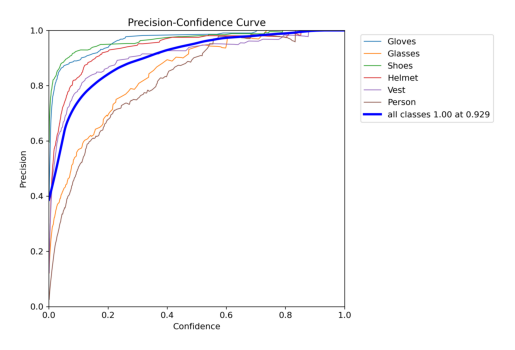



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/R_curve.png


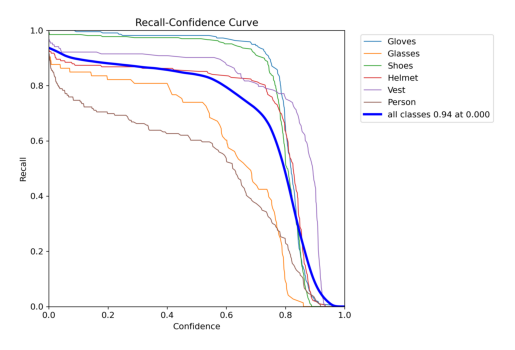



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/confusion_matrix.png


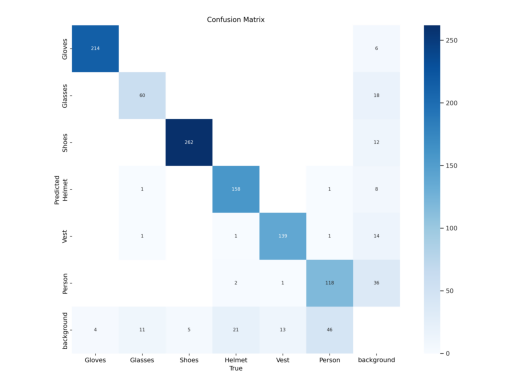



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/confusion_matrix_normalized.png


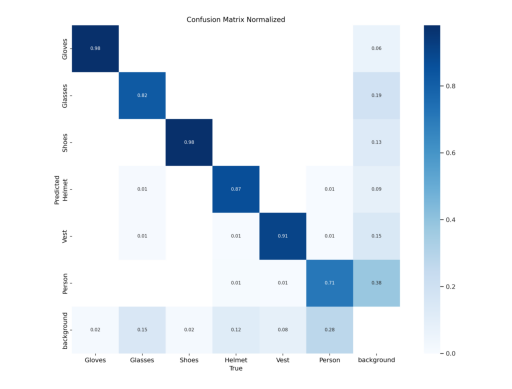



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/labels.jpg


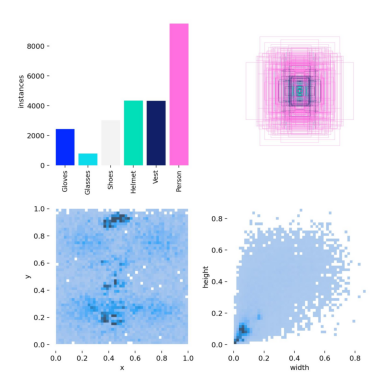



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/labels_correlogram.jpg


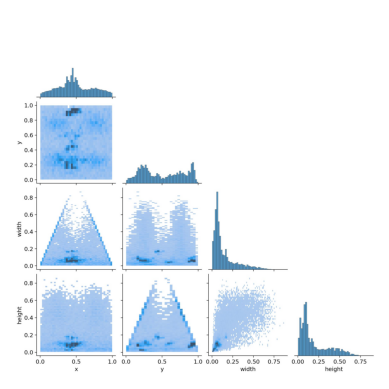



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/results.png


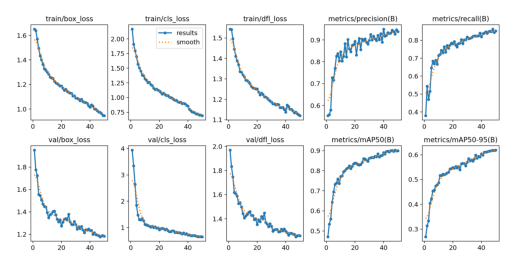

In [24]:
for file in sorted(results_paths):
    print(file)
    display_one_image(file, print_info = False, axis = 'off')
    print('\n')

In [30]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}/{CFG.NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.ARTIFACTS}/training_log_df.csv', index=False)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3559.24,1.65154,2.16823,1.54387,0.55337,0.37898,0.47115,0.26913,1.95140,3.94397,1.96974,0.070098,0.003322,0.003322
1,2,3677.40,1.63891,1.90783,1.54170,0.55875,0.54387,0.53398,0.31285,1.77604,3.34320,1.83342,0.039966,0.006524,0.006524
2,3,3794.15,1.57000,1.79980,1.49633,0.57933,0.46919,0.56016,0.33294,1.72345,2.64165,1.74774,0.009702,0.009594,0.009594
3,4,3910.28,1.49548,1.69853,1.44615,0.72741,0.51493,0.64319,0.40423,1.55520,1.84206,1.61855,0.009406,0.009406,0.009406
4,5,4025.39,1.43305,1.56963,1.41032,0.71549,0.64517,0.69482,0.42215,1.54652,1.47187,1.60789,0.009208,0.009208,0.009208
5,6,4140.92,1.40048,1.50538,1.38796,0.77035,0.68365,0.73267,0.45416,1.50712,1.30200,1.58817,0.009010,0.009010,0.009010
6,7,4258.12,1.36332,1.45190,1.36919,0.82627,0.66891,0.73949,0.45688,1.47050,1.28921,1.52597,0.008812,0.008812,0.008812
7,8,4373.92,1.32850,1.38110,1.33555,0.83720,0.68896,0.75887,0.47388,1.44896,1.34041,1.53399,0.008614,0.008614,0.008614
8,9,4489.88,1.31622,1.36930,1.33328,0.80405,0.66607,0.73625,0.47908,1.44375,1.25171,1.49822,0.008416,0.008416,0.008416
9,10,4605.50,1.30063,1.31967,1.31948,0.84647,0.71536,0.77137,0.48687,1.39468,1.12154,1.44299,0.008218,0.008218,0.008218


In [27]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.94596 , on epoch:  50 


Best Validation Box loss:  1.1776 , on epoch:  47 


Best Training Cls loss:  0.69108 , on epoch:  50 


Best Validation Cls loss:  0.64844 , on epoch:  50 


Best Training DFL loss:  1.11974 , on epoch:  50 


Best Validation DFL loss:  1.25135 , on epoch:  47 



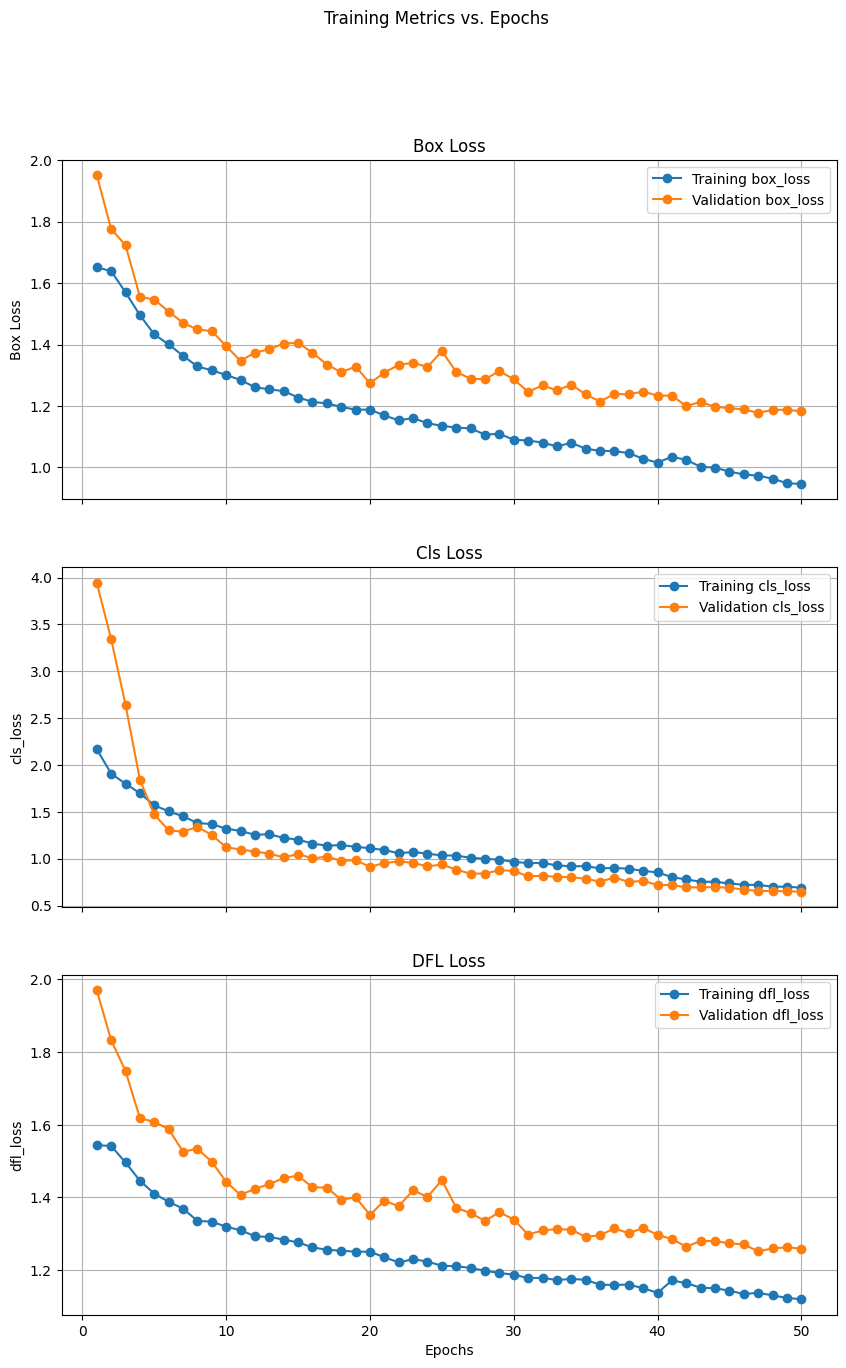

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [32]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}/{CFG.NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}/{CFG.NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [33]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

/content/drive/MyDrive/PPE-detection/runs/detection-PPE/val_batch2_pred.jpg


/content/drive/MyDrive/PPE-detection/runs/detection-PPE/val_batch0_labels.jpg
type : <class 'PIL.JpegImagePlugin.JpegImageFile'>

shape : (1464, 1920, 3)



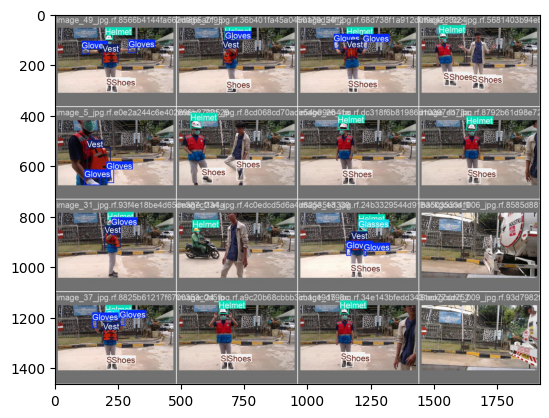



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/val_batch0_pred.jpg
type : <class 'PIL.JpegImagePlugin.JpegImageFile'>

shape : (1464, 1920, 3)



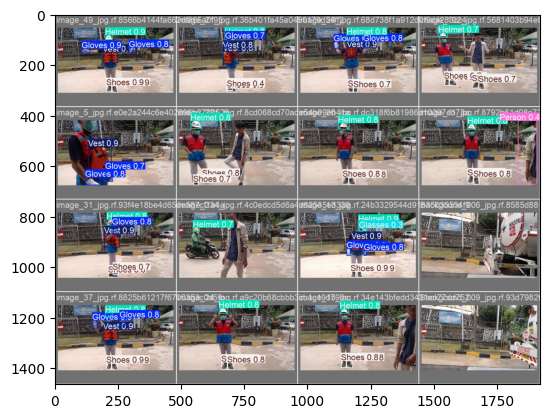



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/val_batch1_labels.jpg
type : <class 'PIL.JpegImagePlugin.JpegImageFile'>

shape : (1464, 1920, 3)



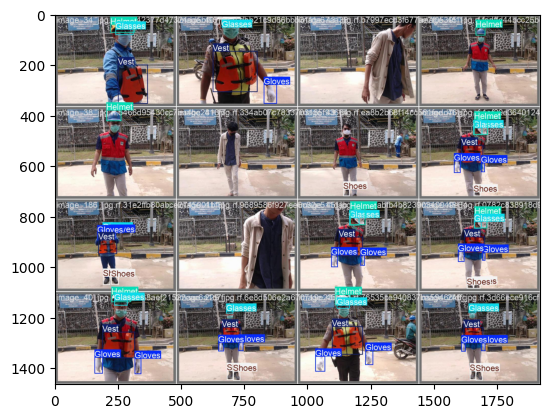



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/val_batch1_pred.jpg
type : <class 'PIL.JpegImagePlugin.JpegImageFile'>

shape : (1464, 1920, 3)



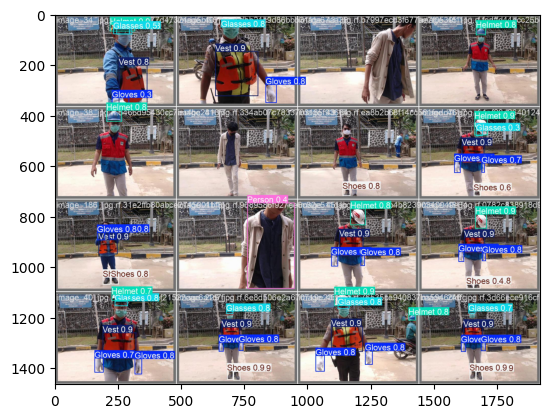



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/val_batch2_labels.jpg
type : <class 'PIL.JpegImagePlugin.JpegImageFile'>

shape : (1464, 1920, 3)



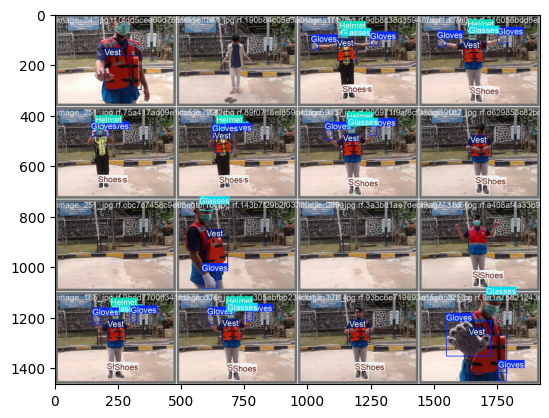



/content/drive/MyDrive/PPE-detection/runs/detection-PPE/val_batch2_pred.jpg
type : <class 'PIL.JpegImagePlugin.JpegImageFile'>

shape : (1464, 1920, 3)



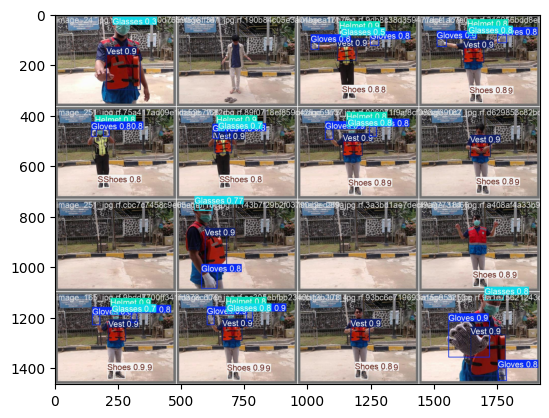

In [41]:
for file in sorted(validation_results_paths):
    print(file)
    display_one_image(file, print_info = True, axis = 'on')
    print('\n')